In [1]:
%matplotlib inline

In [2]:
import json
import pandas as pd

satellites = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            satellites.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'c': int(coords[0] + .5),
                'r': int(coords[1] + .5),
            })
    
satellites = pd.DataFrame(satellites)
satellites = satellites.set_index(['sequence', 'frame', 'satellite'])
satellites.head()

c    r
sequence frame satellite          
1        1     1          502  237
               2          490  222
               3          141  129
         2     1          530  214
               2          518  199

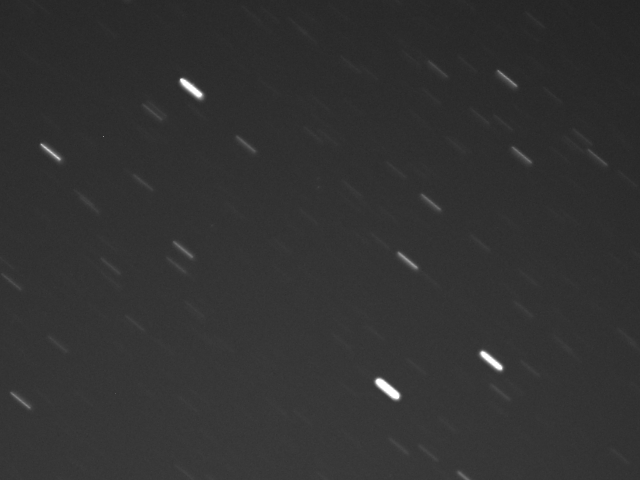

In [3]:
from PIL import Image

sequence = 52
frame = 4
img = Image.open(f'data/spotGEO/train/{sequence}/{frame}.png')
img

In [4]:
import numpy as np
from scipy import ndimage

pixels = np.asarray(img)
ndimage.shift(pixels, shift=(1, 0), mode='nearest')

array([[41, 41, 40, ..., 36, 36, 37],
       [41, 41, 40, ..., 36, 36, 37],
       [39, 41, 40, ..., 35, 36, 36],
       ...,
       [55, 56, 53, ..., 49, 50, 50],
       [52, 53, 53, ..., 53, 51, 49],
       [52, 52, 54, ..., 52, 51, 51]], dtype=uint8)

In [5]:
import itertools

def find_peaks(pixels):
    
    is_peak = np.ones_like(pixels, dtype=bool)

    for i, j in itertools.product([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2]):
        if i == j == 0:
            continue
        
        shifted = ndimage.shift(pixels, shift=(i, j), mode='nearest')
        is_peak &= (pixels >= shifted + 2)
        
    rows, cols = np.meshgrid(np.arange(pixels.shape[1]), np.arange(pixels.shape[0]))
    
    return pd.DataFrame({'r': rows[is_peak], 'c': cols[is_peak]})

peaks = find_peaks(pixels)
print(len(peaks))
peaks.head()

1060


,r,c
0,7,1
1,398,1
2,501,2
3,329,3
4,416,4


In [6]:
776 * 1280

993280

In [7]:
from scipy import optimize
from scipy.spatial import distance

def assign_labels(interesting, satellites):
    
    # Compute the distance between each satellite and each interesting location,
    # thus forming a bipartite graph
    distances = distance.cdist(satellites, interesting, metric='cityblock')
    
    # Guess which locations correspond to which satellites
    row_ind, col_ind = optimize.linear_sum_assignment(distances)

    # Each satellite is assigned, but some of them may be too distant to be likely
    likely = distances[row_ind, col_ind] < 4
    
    labels = np.full(len(interesting), False, dtype=bool)
    labels[col_ind[likely]] = True
    return labels

**True locations**

In [8]:
sats = satellites.loc[sequence, frame]
sats

,c,r
satellite,,
1,452,289
2,318,187
3,317,178
4,212,225
5,193,84


**What we found**

In [9]:
assigned = assign_labels(peaks, sats)
peaks[assigned]

,r,c
370,318,187
436,211,225


**Debugging**

In [10]:
def get_region(img, r, c, w):
    """Returns the square of length width with (r, c) being at the center."""
    return img[
        max(r - w, 0) : min(r + w + 1, img.shape[0]),
        max(c - w, 0) : min(c + w + 1, img.shape[1])
    ]

region = get_region(pixels, r=193, c=84, w=4)
region

array([[47, 48, 49, 50, 50, 47, 49, 48, 47],
       [48, 47, 50, 49, 49, 51, 48, 49, 47],
       [51, 50, 50, 49, 49, 50, 51, 49, 48],
       [53, 51, 49, 49, 49, 50, 51, 49, 49],
       [55, 53, 50, 52, 49, 49, 50, 50, 48],
       [58, 56, 55, 54, 52, 50, 51, 50, 47],
       [60, 62, 59, 57, 54, 53, 52, 50, 48],
       [60, 61, 61, 61, 54, 53, 53, 51, 48],
       [61, 61, 63, 65, 63, 59, 56, 53, 51]], dtype=uint8)

## How well does this perform on the training set?

In [14]:
assignments = []

for sequence in tqdm.tqdm(range(1, 1281), position=0):
    for frame in range(1, 6):

        try:
            sats = satellites.loc[sequence, frame]
        except KeyError:
            continue

        img = Image.open(f'data/spotGEO/train/{sequence}/{frame}.png')
        pixels = np.asarray(img)
        
        peaks = find_peaks(pixels)
        assigned = assign_labels(peaks, sats)
    
        assignments.append([sequence, frame, len(peaks), len(sats), assigned.sum()])
        
        #if len(sats) != assigned.sum():
        #    print(sequence, frame)
    
assignments = pd.DataFrame(assignments, columns=['sequence', 'frame', 'n_peaks', 'n_sats', 'n_matches'])
assignments.head()

100%|██████████| 1280/1280 [1:20:54<00:00,  3.79s/it]  


,sequence,frame,n_peaks,n_sats,n_matches
0,1,1,2436,3,3
1,1,2,2505,3,2
2,1,3,2388,3,3
3,1,4,2456,3,2
4,1,5,2379,3,3


In [15]:
assignments['n_matches'].sum() / assignments['n_sats'].sum()

0.6477465417224454

## Extract peaks for each image

import pathlib
from joblib import Parallel, delayed
import tqdm

def f(part, seq, frame):
    img = np.array(Image.open(frame))
    return find_peaks(img).assign(part=part, sequence=int(seq.name), frame=int(frame.stem))

interesting = Parallel(n_jobs=3)(
    delayed(f)(part, seq, frame)
    for part in ['train', 'test']
    for seq in tqdm.tqdm(list(pathlib.Path(f'data/spotGEO/{part}').glob('*')), position=0)
    for frame in seq.glob('*.png')
)

(
    pd
    .concat(interesting)
    .set_index(['part', 'sequence', 'frame'])
    .to_pickle('data/interesting.pkl')
)

In [11]:
import pathlib
import tqdm

sink = pathlib.Path('data/peaks.csv')
with open(sink, 'w') as f:
    f.write('r,c,part,sequence,frame\n')

for part in ['train', 'test']:
    for seq in tqdm.tqdm(list(pathlib.Path(f'data/spotGEO/{part}').glob('*')), position=0):
        for frame in seq.glob('*.png'):
            img = np.array(Image.open(frame))
            peaks = find_peaks(img).assign(part=part, sequence=int(seq.name), frame=int(frame.stem))            
            peaks.to_csv(sink, mode='a', header=False, index=False)

 10%|█         | 133/1281 [08:43<1:11:04,  3.72s/it]

KeyboardInterrupt: 